In [170]:
import os
from pathlib import Path


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist



In [176]:
CUR_DIR = os.path.abspath('')

DATA_DIR = Path(CUR_DIR).parent / "data"
FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df = pd.read_csv(FILE_PATH, index_col = 0)

In [172]:
df.head()

,user,listening_count,song_name,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,shs_perf,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
1,9fba771d9731561eba47216f6fbfc0023d88641b,19,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
2,85952991b8e3ca5803a08b0b2f9c6d71abf9bb5b,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
3,537340ff896dea11328910013cfe759413e1eeb3,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
4,8fce200f3912e9608e3b1463cdb9c3529aab5c08,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24


In [177]:
len(df)

4982520

In [178]:
## keep first occurence of a given song/artist instance to reduce redundant observations

df = df.drop_duplicates(subset = ['song_name', 'artist_name'], keep='first')
print(df['song_name'].duplicated().sum())
print(len(df))
df

2390
27607


,user,listening_count,song_name,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,shs_perf,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.1760,0.007630,0.000000,0.526,0.495,103.977,4.0,2011-05-24
18315,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stacked Actors,There Is Nothing Left To Lose,Foo Fighters,256.46975,0.839275,0.550762,1999,-1,...,-5.145,1,0.0500,0.002030,0.001020,0.234,0.670,134.898,4.0,1999-11-02
20077,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Clarity,As/Is: Cleveland/Cincinnati_ OH - 8/03-8/04/04,John Mayer,548.88444,0.837948,0.787679,0,-1,...,-3.551,1,0.0384,0.172000,0.032000,0.177,0.491,94.710,4.0,2003-09-09
22873,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Gimme Stitches,There Is Nothing Left To Lose,Foo Fighters,222.19710,0.839275,0.550762,1999,-1,...,-4.215,1,0.0685,0.001750,0.002860,0.263,0.532,111.850,4.0,1999-11-02
23610,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Breakout,There Is Nothing Left To Lose,Foo Fighters,200.80281,0.839275,0.550762,1999,-1,...,-4.212,0,0.0522,0.000052,0.002910,0.124,0.427,156.794,4.0,1999-11-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982515,3796a24e109961914e04fc82f05e727751eba723,1,Dime,20th Anniversary,Jerry Rivera,284.29016,0.650177,0.404963,2001,-1,...,-9.949,1,0.0403,0.784000,0.000000,0.217,0.805,87.814,4.0,2016-08-12
4982516,61457d4f6b5053031c358de46929960f3d32d782,1,The Long Conversation,The Way That It Was,Pierre de Reeder,184.65914,0.511732,0.344567,2008,-1,...,-10.025,1,0.0273,0.826000,0.033700,0.369,0.219,97.379,4.0,2010-04-20
4982517,61457d4f6b5053031c358de46929960f3d32d782,1,That's the Way That It Was,The Way That It Was,Pierre de Reeder,167.28771,0.511732,0.344567,2008,-1,...,-5.848,1,0.0370,0.030500,0.000079,0.112,0.304,135.861,4.0,2010-04-20
4982518,bd0c3b42396ea8a1225eba1ac8c398b940e1b060,3,I'll Close My Eyes,Runnin Wild,Mike Jones,265.79546,0.793605,0.426318,0,-1,...,-24.078,1,0.0350,0.982000,0.899000,0.839,0.247,69.497,4.0,1994


## Songs features selection

In [179]:
df.columns

Index(['user', 'listening_count', 'song_name', 'release', 'artist_name',
       'duration', 'artist_familiarity', 'artist_hotttnesss', 'year',
       'shs_perf', 'shs_work', 'explicit', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'release_date'],
      dtype='object')

In [180]:
tracks_feats = df.drop(['user', 'listening_count'],axis = 1).drop_duplicates()
len(tracks_feats)

27607

In [181]:
artists = tracks_feats.artist_name
songs = tracks_feats.song_name
release = tracks_feats.release

labels = artists + '-' + songs

In [182]:
labels.head()

0                Kanye West-Stronger
18315    Foo Fighters-Stacked Actors
20077             John Mayer-Clarity
22873    Foo Fighters-Gimme Stitches
23610          Foo Fighters-Breakout
dtype: object

In [183]:
## Quantitative feats only
tracks_quanti_feats = tracks_feats.drop(['song_name', 'release', 'artist_name',
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date'], axis = 1)

In [184]:
tracks_quanti_feats.columns

Index(['duration', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

## Univariate statistics description

In [185]:

tracks_quanti_feats.describe()

,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000,27607.000000
mean,243.041990,0.510666,0.640636,-8.975722,0.079329,0.274477,0.204682,0.214115,0.480693,121.608547
std,108.629287,0.178896,0.255091,4.443141,0.099464,0.323391,0.328249,0.187735,0.259870,30.096860
min,4.074650,0.000000,0.000020,-44.534000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,184.685260,0.382000,0.456000,-11.186500,0.033800,0.006125,0.000005,0.097400,0.265000,98.063000
50%,229.955460,0.515000,0.682000,-8.050000,0.045100,0.106000,0.001810,0.134000,0.473000,119.853000
75%,280.920360,0.642000,0.863000,-5.850000,0.077000,0.512000,0.331000,0.280000,0.689000,140.023500
max,2999.509750,0.978000,1.000000,3.599000,0.963000,0.996000,0.997000,0.997000,1.000000,231.028000


## Bivariate statistcal analysis

<Axes: >

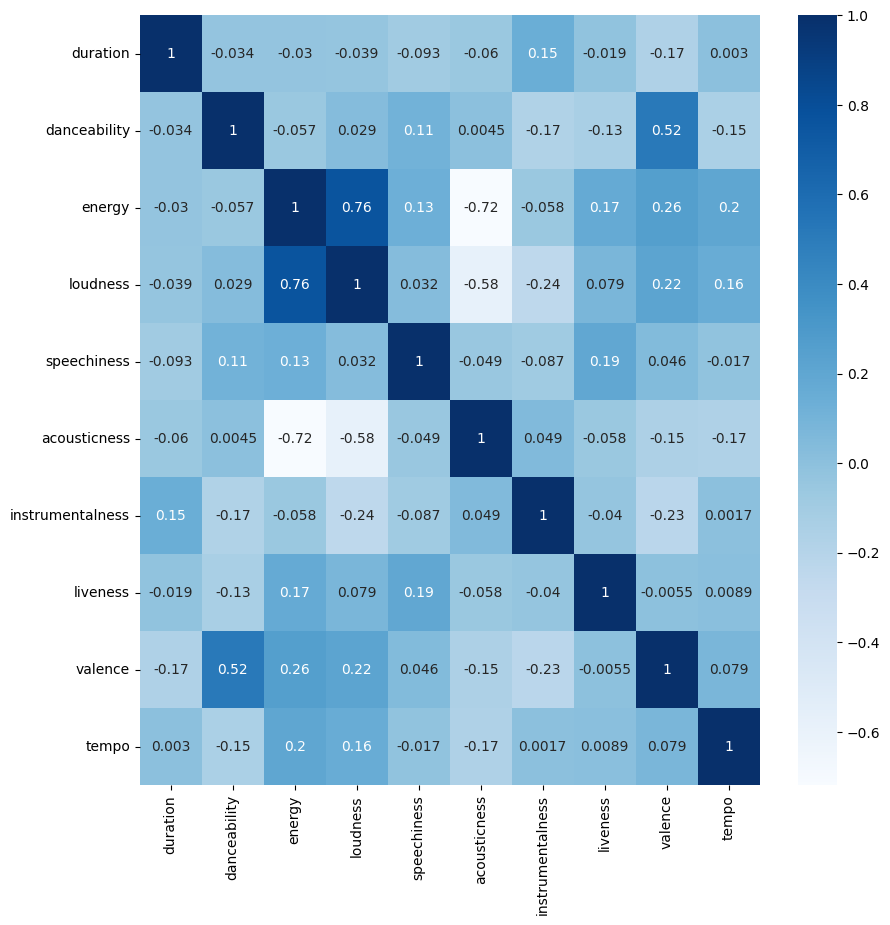

In [186]:
corr = tracks_quanti_feats.corr()
plt.figure(figsize =(10,10))
sns.heatmap(corr, cmap="Blues", annot=True)

There are no clear correlation between the variables, except
- a rather strong positive correlation between energy and loudness,
- a medium positive correlation between valence and danceability
- a rather strong negative correlation between energy and acousticness

## Multivariate quantitative analysis : PCA

In [187]:
scaler = StandardScaler()
scaler.fit(tracks_quanti_feats)
#X = scaler.transform(tracks_quanti_feats)
## preserve X as a dataframe
X = tracks_quanti_feats
X[X.columns] = pd.DataFrame(scaler.fit_transform(X), index=X.index)

In [188]:

pca = PCA()

reduced = pca.fit_transform(X)

# Append the principle components for each entry to the dataframe
# for i in range(0, n_components):
#     df['PC' + str(i + 1)] = reduced[:, i]

# display(df.head())

# Do a scree plot


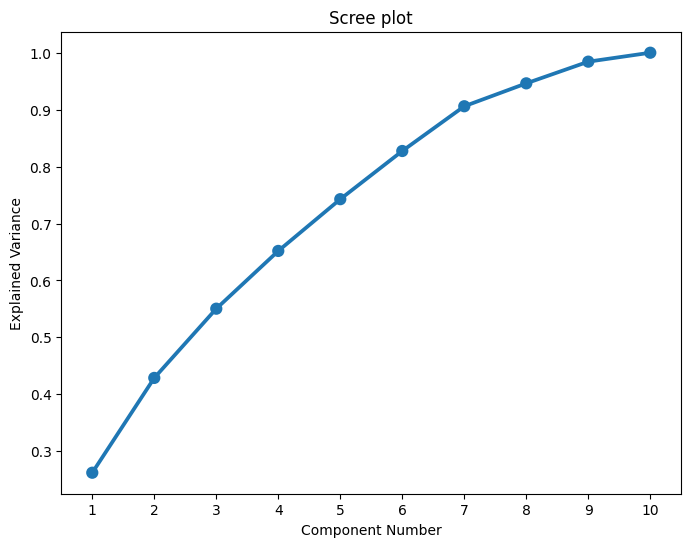

In [189]:
ind = np.arange(0, reduced.shape[1])
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=np.cumsum(pca.explained_variance_ratio_))
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind+1)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

There is not a clear elbow on the explained variance.
Almost 7 components are necessary to explain more than 90% of the variance while the original dataset have 10 variables.

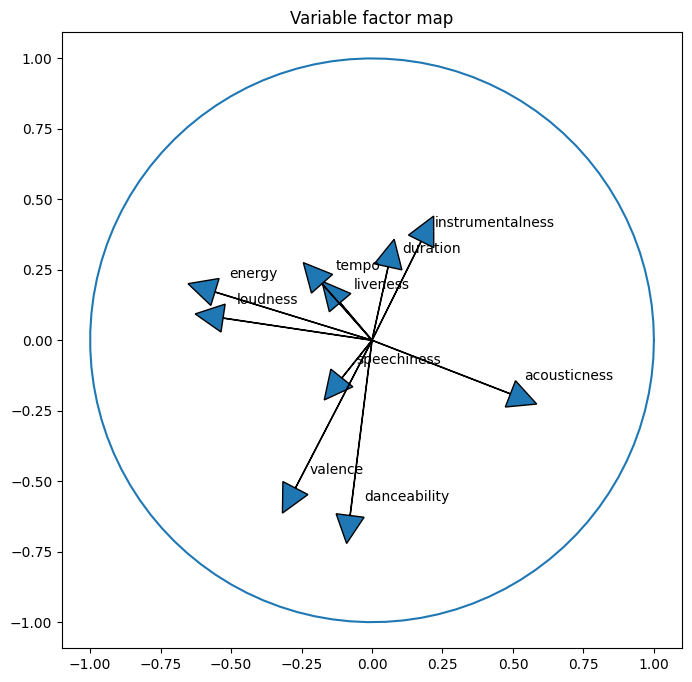

In [190]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             tracks_quanti_feats.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

There is no good correlation between the variables and the first and second component of the ACP.
It is not clear

This short analysis demonstrate that a ACP transformation will not have a clear interest for the dataset.

## Clustering analysis

In [191]:
# Kmeans

distorsions = []

for i in range(100):
#     print(i+2)
    clf = KMeans(n_clusters = i+2, n_init = 'auto')
    clf.fit(X)
    centroids = clf.cluster_centers_
    labels = clf.labels_
    distorsions.append(sum(np.min(cdist(XA = centroids, XB = X, metric='euclidean'), axis = 0)) / len(df))

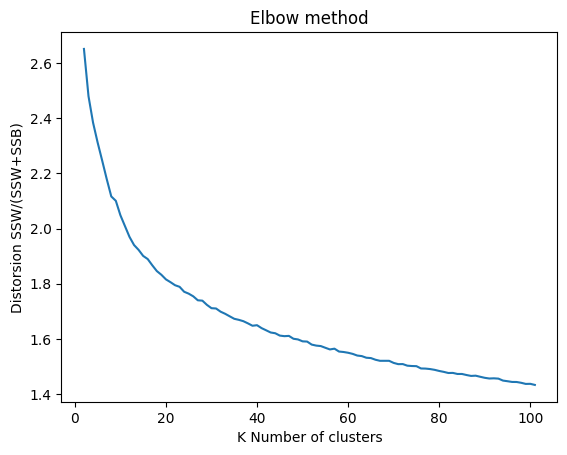

In [193]:
plt.plot([i+2 for i in range(100)], distorsions);
plt.xlabel('K Number of clusters')
plt.ylabel('Distorsion SSW/(SSW+SSB)')
plt.title('Elbow method');


In [194]:

clf = KMeans(n_clusters = 20, n_init = 'auto')
clf.fit(X)
centroids = clf.cluster_centers_
labels = clf.labels_
distorsions = sum(np.min(cdist(XA = centroids, XB = X, metric='euclidean'), axis = 0)) / len(df)

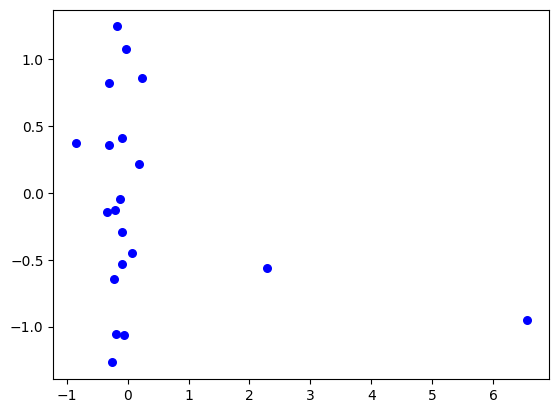

In [195]:
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "o", color = "blue", s=30, linewidths = 1, zorder = 10)

plt.show()

In [196]:
# Hierarchical Clustering
Z = linkage(X, method = 'ward', metric = 'euclidean')

In [198]:
range_n_clusters = [i+2 for i in range(50)]

s_scores = []
for k in range_n_clusters:
    #display(k)
    labels = fcluster(Z, t=k, criterion='maxclust')
    s_scores.append(silhouette_score(X, labels, metric='sqeuclidean'))

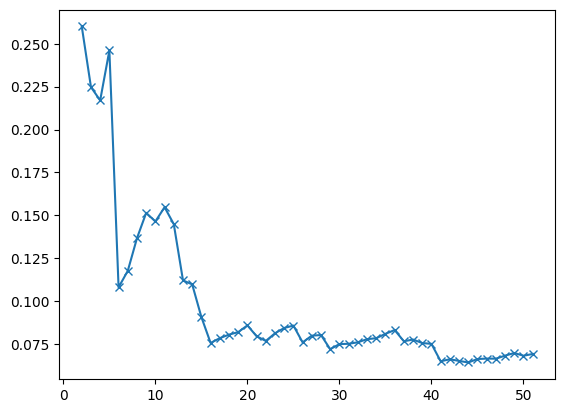

In [199]:
plt.plot(range_n_clusters, s_scores, '-x');

The removal of redundant information by dropping duplicates of song/artist observations changed the overall silhouette score profile from the initial entire tracks_quanti_feats df

Focus on a smaller ranger of clusters

In [200]:
range_n_clusters = [i+2 for i in range(15)]
s_scores = []
for n_clusters in range_n_clusters:
    cluster = AgglomerativeClustering(n_clusters=n_clusters)
    cluster.fit(X)
    labels = cluster.labels_
    score = silhouette_score(X, labels, metric='sqeuclidean')
    s_scores.append(score)

The best silhouette score seems to lie between 2 and 5 clusters 

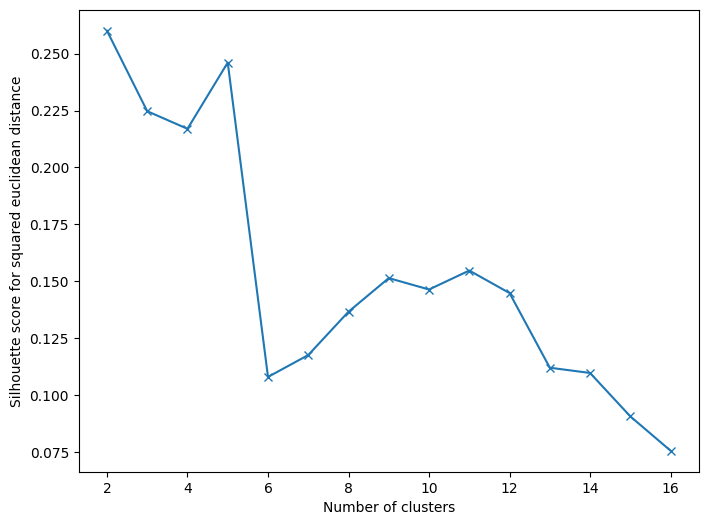

In [208]:
fig, ax1  = plt.subplots(figsize=(8, 6))

ax1.plot(range_n_clusters, s_scores, '-x')
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Silhouette score for squared euclidean distance");



In [202]:
Z = linkage(X, method ='ward', metric ='euclidean')

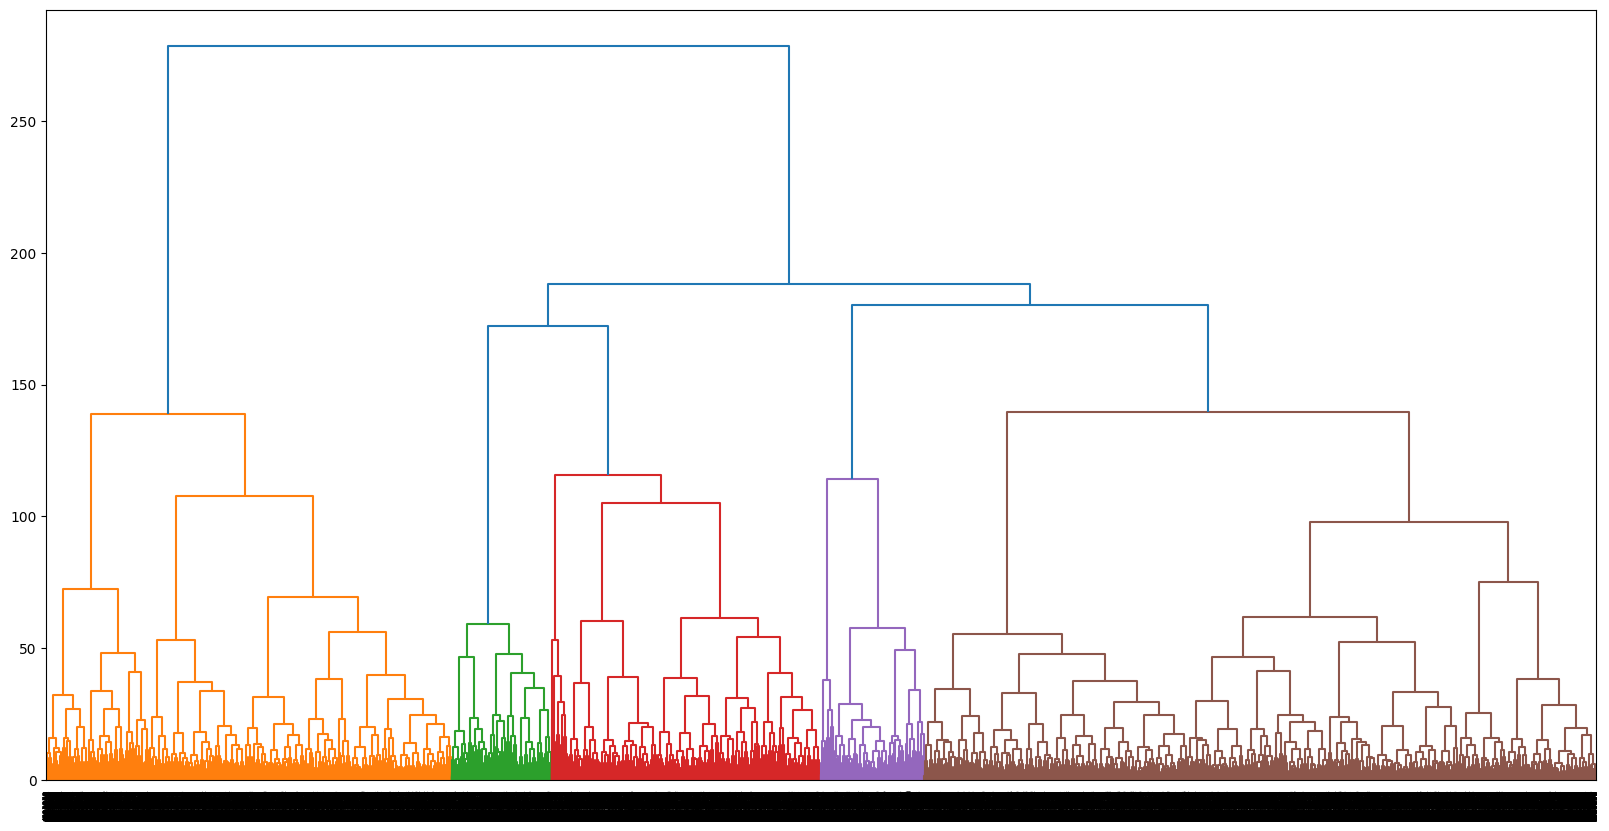

In [203]:
from scipy.cluster.hierarchy import dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, labels = tracks_quanti_feats.index, leaf_rotation= 90, color_threshold = 140)
plt.show()

Two clusters seems like a huge jump, 5 clusters appears to be more conservative as indicated by the dendrogram

In [213]:
n_clusters_cah = 5
cluster = AgglomerativeClustering(n_clusters=n_clusters_cah)
cluster.fit(X)

cah_clusters = cluster.labels_


In [221]:
print(np.unique(cah_clusters))
cah_clusters = cah_clusters.astype('object')

cah_clusters[cah_clusters==0] = 'A'
cah_clusters[cah_clusters==1] = 'B'
cah_clusters[cah_clusters==2] = 'C'
cah_clusters[cah_clusters==3] = 'D'
cah_clusters[cah_clusters==4] = 'E'


['A' 'B' 'C' 'D' 'E']


In [222]:
X['hac_clusters'] = cah_clusters
#X['song_name'] = tracks_feats['song_name']
print(X['hac_clusters'].unique())


['D' 'A' 'B' 'C' 'E']


In [223]:
X


,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,hac_clusters
0,0.633426,0.667073,0.244482,0.234685,0.971940,-0.825165,-0.623569,1.661334,0.055057,-0.585837,D
18315,0.123613,-0.048441,1.150060,0.862181,-0.294877,-0.842482,-0.620462,0.105924,0.728483,0.441564,A
20077,2.815521,0.868312,0.283685,1.220943,-0.411504,-0.316887,-0.526080,-0.197701,0.039664,-0.893749,A
22873,-0.191894,0.180747,1.244146,1.071496,-0.108876,-0.843348,-0.614856,0.260399,0.197438,-0.324244,A
23610,-0.388845,-0.501227,1.165741,1.072171,-0.272758,-0.848599,-0.614704,-0.480018,-0.206617,1.169095,A
...,...,...,...,...,...,...,...,...,...,...,...
4982515,0.379722,0.991291,-0.429800,-0.219056,-0.392401,1.575591,-0.623569,0.015369,1.247983,-1.122880,A
4982516,-0.537460,-0.395018,-1.370660,-0.236161,-0.523105,1.705467,-0.520901,0.825034,-1.007032,-0.805067,B
4982517,-0.697378,0.583224,0.228801,0.703957,-0.425580,-0.754445,-0.623329,-0.543939,-0.679940,0.473561,A
4982518,0.209464,-0.283219,-2.126092,-3.399071,-0.445688,2.187863,2.115258,3.328605,-0.899284,-1.731493,E


C:\Users\benoit\AppData\Local\Temp\ipykernel_26000\4036850946.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(251)


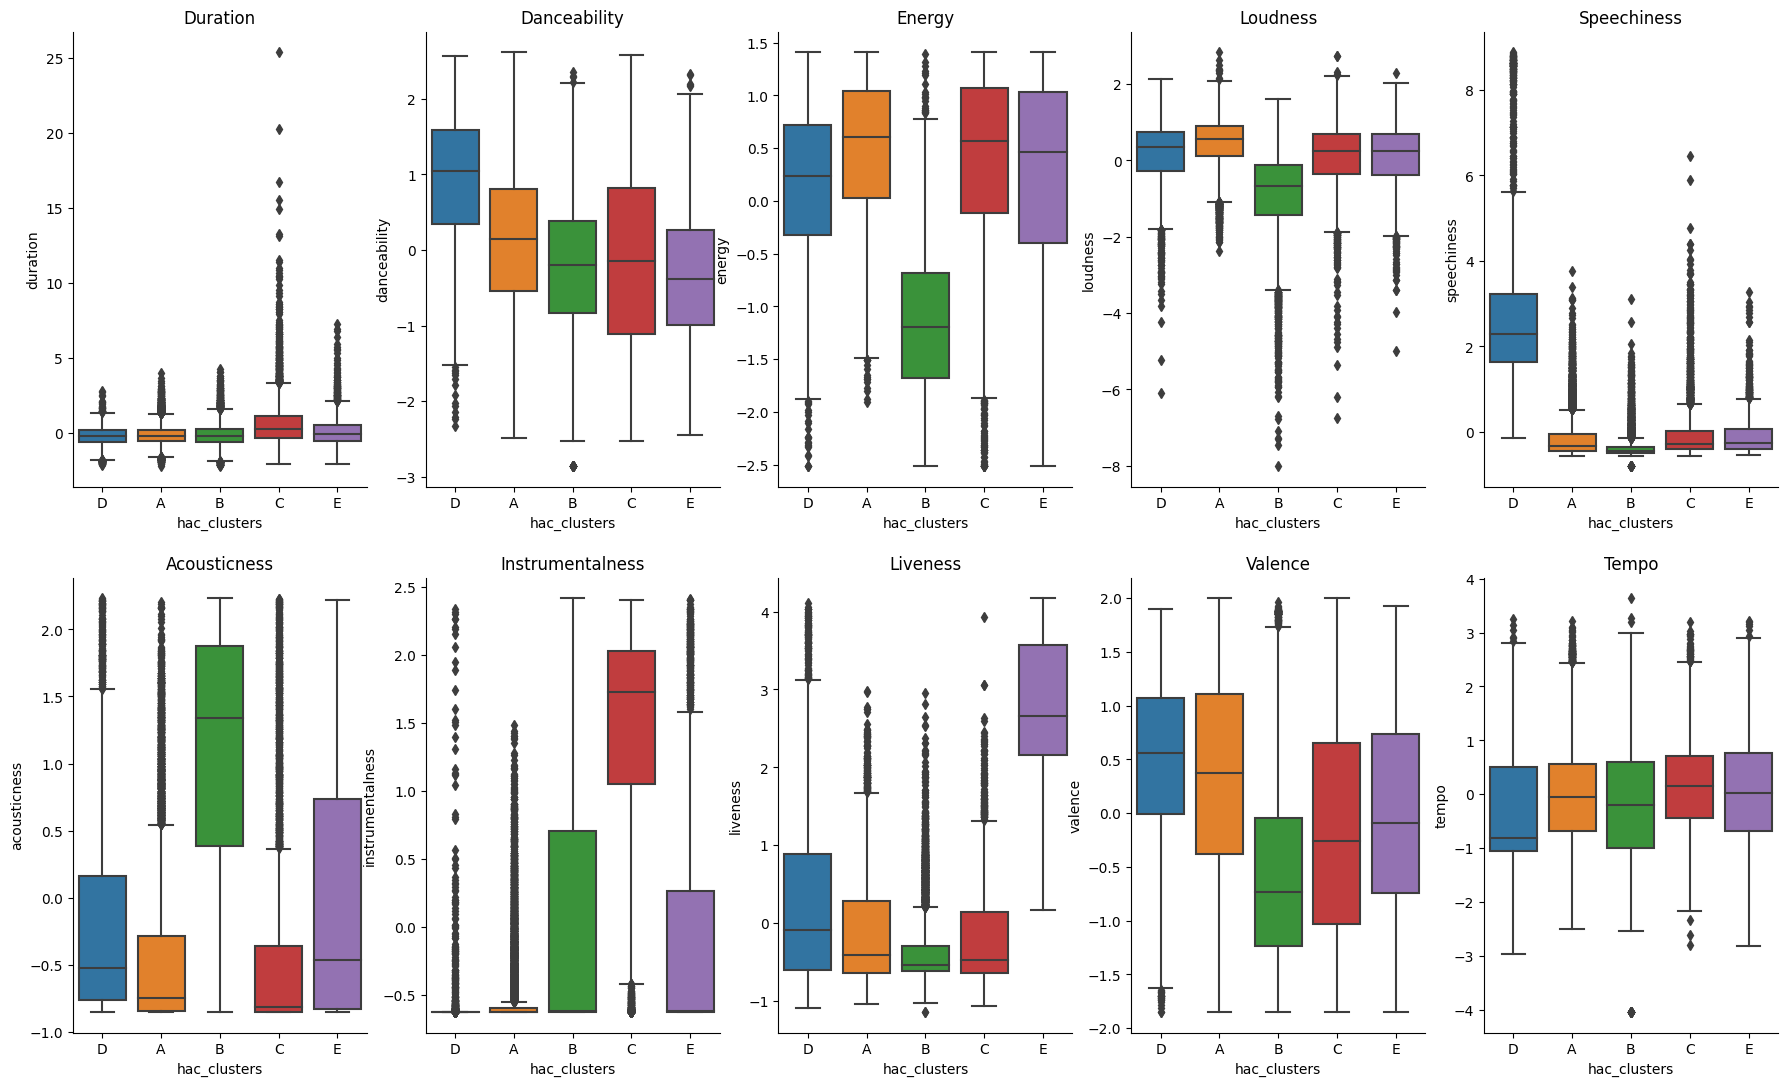

In [224]:
fig = plt.subplots(figsize=(22, 13))

ax1 = plt.subplot(251)
a = sns.boxplot(x='hac_clusters', y='duration', hue = 'hac_clusters', data=X, dodge=False, ax=ax1)
a.legend_.remove()
a.set_title("Duration")
sns.despine()

ax2 = plt.subplot(252)
b = sns.boxplot(x='hac_clusters', y='danceability', hue = 'hac_clusters', data=X, dodge=False, ax=ax2)
b.legend_.remove()
b.set_title("Danceability")
sns.despine()

ax3 = plt.subplot(253)
c = sns.boxplot(x='hac_clusters', y='energy', hue = 'hac_clusters', data=X, dodge=False, ax=ax3)
c.legend_.remove()
c.set_title("Energy")
sns.despine()

ax4 = plt.subplot(254)
d = sns.boxplot(x='hac_clusters', y='loudness', hue = 'hac_clusters', data=X, dodge=False, ax=ax4)
d.legend_.remove()
d.set_title("Loudness")
sns.despine()

ax5 = plt.subplot(255)
e = sns.boxplot(x='hac_clusters', y='speechiness', hue = 'hac_clusters', data=X, dodge=False, ax=ax5)
e.set_title("Speechiness")
e.legend_.remove()

sns.despine()

ax6 = plt.subplot(256)
f = sns.boxplot(x='hac_clusters', y='acousticness', hue = 'hac_clusters', data=X, dodge=False, ax=ax6)
f.legend_.remove()
f.set_title("Acousticness")
sns.despine()

ax7 = plt.subplot(257)
g = sns.boxplot(x='hac_clusters', y='instrumentalness', hue = 'hac_clusters', data=X, dodge=False, ax=ax7)
g.legend_.remove()
g.set_title("Instrumentalness")
sns.despine()

ax8 = plt.subplot(258)
h = sns.boxplot(x='hac_clusters', y='liveness', hue = 'hac_clusters', data=X, dodge=False, ax=ax8)
h.legend_.remove()
h.set_title("Liveness")
sns.despine()

ax9 = plt.subplot(259)
i = sns.boxplot(x='hac_clusters', y='valence', hue = 'hac_clusters', data=X, dodge=False, ax=ax9)
i.legend_.remove()
i.set_title("Valence")
sns.despine()

ax10 = plt.subplot(2,5,10)
j = sns.boxplot(x='hac_clusters', y='tempo', hue = 'hac_clusters', data=X, dodge=False, ax=ax10)
j.legend_.remove()
j.set_title("Tempo")
sns.despine()



In [228]:
df_mapping = X
df_mapping['song_name'] =  df['song_name']
df_mapping['artist_name'] =  df['artist_name']
df_mapping

,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,hac_clusters,song_name,artist_name
0,0.633426,0.667073,0.244482,0.234685,0.971940,-0.825165,-0.623569,1.661334,0.055057,-0.585837,D,Stronger,Kanye West
18315,0.123613,-0.048441,1.150060,0.862181,-0.294877,-0.842482,-0.620462,0.105924,0.728483,0.441564,A,Stacked Actors,Foo Fighters
20077,2.815521,0.868312,0.283685,1.220943,-0.411504,-0.316887,-0.526080,-0.197701,0.039664,-0.893749,A,Clarity,John Mayer
22873,-0.191894,0.180747,1.244146,1.071496,-0.108876,-0.843348,-0.614856,0.260399,0.197438,-0.324244,A,Gimme Stitches,Foo Fighters
23610,-0.388845,-0.501227,1.165741,1.072171,-0.272758,-0.848599,-0.614704,-0.480018,-0.206617,1.169095,A,Breakout,Foo Fighters
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982515,0.379722,0.991291,-0.429800,-0.219056,-0.392401,1.575591,-0.623569,0.015369,1.247983,-1.122880,A,Dime,Jerry Rivera
4982516,-0.537460,-0.395018,-1.370660,-0.236161,-0.523105,1.705467,-0.520901,0.825034,-1.007032,-0.805067,B,The Long Conversation,Pierre de Reeder
4982517,-0.697378,0.583224,0.228801,0.703957,-0.425580,-0.754445,-0.623329,-0.543939,-0.679940,0.473561,A,That's the Way That It Was,Pierre de Reeder
4982518,0.209464,-0.283219,-2.126092,-3.399071,-0.445688,2.187863,2.115258,3.328605,-0.899284,-1.731493,E,I'll Close My Eyes,Mike Jones


In [229]:
df_mapping = df_mapping.drop(['duration', 'danceability', 'energy',
                              'loudness', 'speechiness', 'acousticness',
                              'instrumentalness', 'liveness', 'valence', 'tempo'],
                              axis=1)
df_mapping

,hac_clusters,song_name,artist_name
0,D,Stronger,Kanye West
18315,A,Stacked Actors,Foo Fighters
20077,A,Clarity,John Mayer
22873,A,Gimme Stitches,Foo Fighters
23610,A,Breakout,Foo Fighters
...,...,...,...
4982515,A,Dime,Jerry Rivera
4982516,B,The Long Conversation,Pierre de Reeder
4982517,A,That's the Way That It Was,Pierre de Reeder
4982518,E,I'll Close My Eyes,Mike Jones


In [231]:
df_mapping[df_mapping['song_name']=='Stronger']

,hac_clusters,song_name,artist_name
0,D,Stronger,Kanye West
1925899,A,Stronger,Britney Spears
4906110,A,Stronger,Will Young
4946101,B,Stronger,Carlene Carter
4963796,A,Stronger,Mieka Pauley


In [257]:
df_origin = pd.read_csv(FILE_PATH)

Broadcast hac_clusters of df_mapping for same song_name/artist_name couple for each user

In [260]:
#df_origin['hac_clusters'] = df_mapping['hac_clusters']
## Broadcast hac_clusters of df_mapping for same song_name/artist_name 
df_origin = pd.merge(df_origin, df_mapping, on=['song_name', 'artist_name'], how='left')

In [262]:
df_origin = df_origin.drop(['hac_clusters_x', 'Unnamed: 0'], axis=1)
df_origin = df_origin.rename(columns={'hac_clusters_y' : 'hac_clusters'})

In [263]:
df_origin

,user,listening_count,song_name,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,shs_perf,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date,hac_clusters
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0,0.1760,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,D
1,9fba771d9731561eba47216f6fbfc0023d88641b,19,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0,0.1760,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,D
2,85952991b8e3ca5803a08b0b2f9c6d71abf9bb5b,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0,0.1760,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,D
3,537340ff896dea11328910013cfe759413e1eeb3,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0,0.1760,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,D
4,8fce200f3912e9608e3b1463cdb9c3529aab5c08,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,0,0.1760,0.00763,0.000000,0.526,0.495,103.977,4.0,2011-05-24,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982515,3796a24e109961914e04fc82f05e727751eba723,1,Dime,20th Anniversary,Jerry Rivera,284.29016,0.650177,0.404963,2001,-1,...,1,0.0403,0.78400,0.000000,0.217,0.805,87.814,4.0,2016-08-12,A
4982516,61457d4f6b5053031c358de46929960f3d32d782,1,The Long Conversation,The Way That It Was,Pierre de Reeder,184.65914,0.511732,0.344567,2008,-1,...,1,0.0273,0.82600,0.033700,0.369,0.219,97.379,4.0,2010-04-20,B
4982517,61457d4f6b5053031c358de46929960f3d32d782,1,That's the Way That It Was,The Way That It Was,Pierre de Reeder,167.28771,0.511732,0.344567,2008,-1,...,1,0.0370,0.03050,0.000079,0.112,0.304,135.861,4.0,2010-04-20,A
4982518,bd0c3b42396ea8a1225eba1ac8c398b940e1b060,3,I'll Close My Eyes,Runnin Wild,Mike Jones,265.79546,0.793605,0.426318,0,-1,...,1,0.0350,0.98200,0.899000,0.839,0.247,69.497,4.0,1994,E


In [288]:
#df_origin[df_origin['user'] == "b80344d063b5ccb3212f76538f3d9e43d87dca9e"]
#df_origin[df_origin['user'] == "22e08d5e101ab5b86dc394856d508e175a5242a6"]
df_origin[df_origin['user'] == "9d17a429365653228049e8fe3d5968d4cd5dc6fe"]


,user,listening_count,song_name,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,shs_perf,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date,hac_clusters
4443425,9d17a429365653228049e8fe3d5968d4cd5dc6fe,1045,Der Kommissar,Vienna Greatest Hits,Falco,228.88444,0.674465,0.485782,1981,-1,...,0,0.0455,0.085,0.000006,0.0711,0.913,118.243,4.0,1999-09-14,A


In [291]:
## function to loop over the df to obtain fraction of listenings per classes

def get_user_class_fraction(df : pd.DataFrame, user_id: str, clusters: list[str]):
    total_listening = df[df["user"] == user_id]["listening_count"].sum() 
    clusters.sort()
    listening_classes = []
    for cluster in clusters:
        listening_classes.append(df[(df["user"] == user_id) & (df["hac_clusters"] == cluster)]["listening_count"].sum() / total_listening)
    return total_listening, listening_classes



In [292]:
## Loop for each class, for top 10 extreme and various users to obtain the fraction of listenings per class and the total number of listenings

ach_list = ['A', 'B', 'C', 'D', 'E']
top_10_various_listeners = ["ec6dfcf19485cb011e0b22637075037aae34cf26", "4e73d9e058d2b1f2dba9c1fe4a8f416f9f58364f",
                    "952130c8ae0527458c75471812dbb5c506b46d5d", "b4c94d72b15d3c311c10045a58b31f95d9d12785",
                    "8192a1d3ca0afbbcf1c98d7062d573e9207078e6", "6d625c6557df84b60d90426c0116138b617b9449",
                    "8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc", "fef771ab021c200187a419f5e55311390f850a50",
                    "cbc7bddbe3b2f59fdbe031b3c8d0db4175d361e6", "726da71c2c2ea119119a7957517fccd028d1be76"]

top_10_v_n = []
top_10_various_users = []
for i in top_10_various_listeners:
    listen_n, classes = get_user_class_fraction(df=df_origin, user_id=i, clusters = ach_list)
    top_10_v_n.append(listen_n)
    top_10_various_users.append(classes)


top_10_listeners = ["22e08d5e101ab5b86dc394856d508e175a5242a6", "af3ee32357049dd96231238bd1b019e8142ee6aa",
                    "6a6d346cc92ee699a765a06fd97db74b864a8129", "3fa44653315697f42410a30cb766a4eb102080bb",
                    "6a46aee45cc177cf8e2025e59d21c7939902deee", "716ed1ec67d67bfa05db3ffeb641d13f46dca6ec",
                    "9755e6e2faf1ba2e1e46f8227690847511425bab", "44d6db05e087361c30a3862db756b9530b5ed14d",
                    "19a7ec5c51a370817f99cf18decde4b8f469bfd3", "9d17a429365653228049e8fe3d5968d4cd5dc6fe"]

top_10_n = []
top_10_users = []
for i in top_10_various_listeners:
    listen_n, classes = get_user_class_fraction(df=df_origin, user_id=i, clusters = ach_list)
    top_10_n.append(listen_n)
    top_10_users.append(classes)



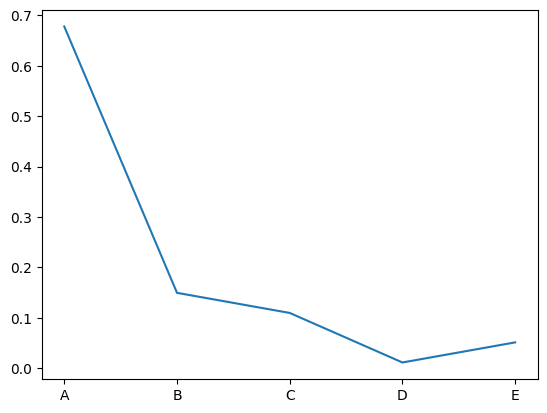

In [312]:
plt.plot(ach_list, top_10_various_users[1])